In [50]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score

from kaggle.api.kaggle_api_extended import KaggleApi
import kagglehub

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset,  Subset
from torchvision import datasets, transforms, models
import torch.optim as optim

from collections import defaultdict

In [2]:
api = KaggleApi()
api.authenticate()

In [3]:
!chcp 65001
path = %pwd

Active code page: 65001


In [4]:
api.dataset_download_files('swoyam2609/fresh-and-stale-classification', path = path, unzip = True)

In [49]:
os.listdir()

['.ipynb_checkpoints', '5 лаба.ipynb', 'dataset']

In [6]:
# %cd dataset/Train
# print(len(os.listdir()))
# %cd ../..

In [20]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

In [21]:
def load_balanced_imagefolder_dataset(data_dir):

    full_dataset = datasets.ImageFolder(data_dir, transform=transform)

    class_indices = defaultdict(list)
    for idx, (_, label) in enumerate(full_dataset.samples):
        class_indices[label].append(idx)

    min_count = min(len(indices) for indices in class_indices.values())
    print(f"Нижняя граница: {min_count}")

    balanced_indices = []
    for indices in class_indices.values():
        balanced_indices.extend(random.sample(indices, min_count))

    balanced_dataset = Subset(full_dataset, balanced_indices)
    return balanced_dataset

In [24]:
# train_dataset = load_balanced_imagefolder_dataset('dataset/Train')
# test_dataset = load_balanced_imagefolder_dataset('dataset/Test')

In [25]:
train_dataset = datasets.ImageFolder('dataset/Train', transform=transform)
test_dataset = datasets.ImageFolder('dataset/Test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [26]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # Первый слой свертки
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.2)
        # Второй слой свертки
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.2)
        
        # Полносвязные слои
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(64, 128)  
        self.fc2 = nn.Linear(128, 14)  
    
    def forward(self, x):
        # Первая свертка
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        
        # Вторая свертка
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        
        # Приводим к линейному виду
        x = self.gap(x)  
        x = x.view(x.size(0), -1) 
        
        # Полносвязные слои
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001) 

correct = 0
total = 0

losses = []
accuracy_arr = []

epochs = 12
for epoch in range(epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    accuracy = (100* correct / total)
    accuracy_arr.append(accuracy)
    
    print(f'Эпоха {epoch+1}, Потеря: {loss.item():.4f}, Accuracy: {accuracy:.2f}')

Эпоха 1, Потеря: 0.4478, Accuracy: 52.61
Эпоха 2, Потеря: 0.7846, Accuracy: 61.23
Эпоха 3, Потеря: 0.6776, Accuracy: 66.43
Эпоха 4, Потеря: 0.4862, Accuracy: 69.86
Эпоха 5, Потеря: 0.2394, Accuracy: 72.22
Эпоха 6, Потеря: 0.3181, Accuracy: 74.17
Эпоха 7, Потеря: 0.6196, Accuracy: 75.71
Эпоха 8, Потеря: 0.2919, Accuracy: 76.95
Эпоха 9, Потеря: 0.2872, Accuracy: 78.04
Эпоха 10, Потеря: 0.2217, Accuracy: 78.96
Эпоха 11, Потеря: 0.3800, Accuracy: 79.80
Эпоха 12, Потеря: 0.2183, Accuracy: 80.51


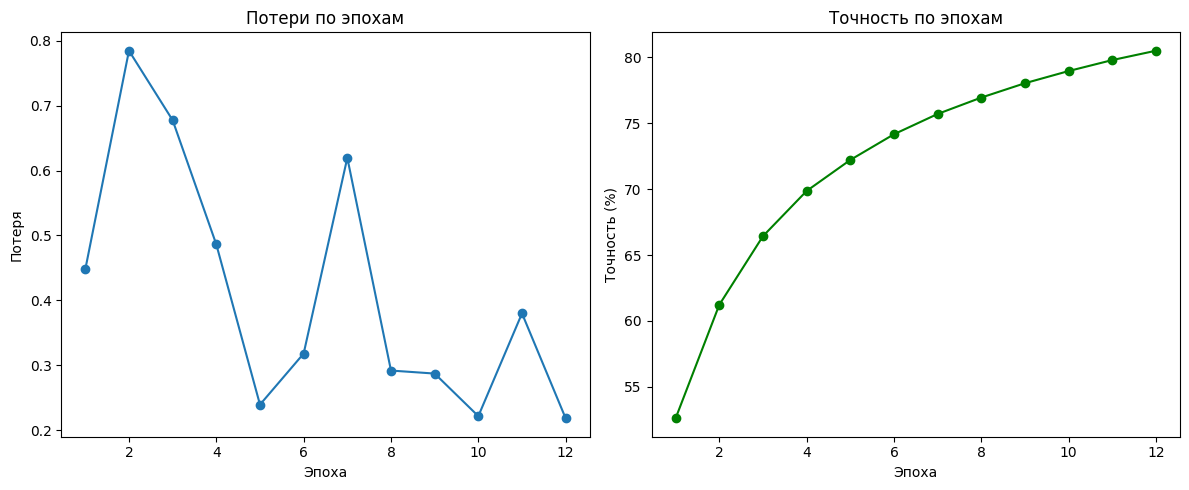

In [46]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), losses, marker='o')
plt.title('Потери по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), accuracy_arr, marker='o', color='green')
plt.title('Точность по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Точность (%)')

plt.tight_layout()
plt.show()

In [54]:
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
f1 = f1_score(all_labels, all_preds, average='weighted')  

print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Test F1-score: {(f1 * 100):.2f}%")


Test Accuracy: 85.05%
Test F1-score: 84.99%
